In [1]:
from pathlib import Path
import pandas as pd

# Path to your data folder (relative to this notebook in EDA/)
data_folder = Path("../Data/Data_25_companies")

# List of 25 company files to include
target_files = {
    "DLF_minute.csv",
    "AMBUJACEM_minute.csv",
    "SHREECEM_minute.csv",
    "NMDC_minute.csv",
 }

# Get only those CSV files that match the target filenames
csv_files = [
    fp for fp in data_folder.glob("*_minute.csv")
    if fp.name in target_files
]

print("Found CSV files:", len(csv_files))
print([fp.name for fp in csv_files])

all_dfs = []
company_id_map = {}
next_company_id = 1

for file_path in csv_files:
    # Extract company name: "DMART_minute.csv" -> "DMART"
    company_name = file_path.stem.split("_")[0]

    # Assign a unique serial number for each company
    if company_name not in company_id_map:
        company_id_map[company_name] = next_company_id
        next_company_id += 1

    company_id = company_id_map[company_name]

    # Read the CSV
    df = pd.read_csv(file_path)

    # Add the two required columns
    df["company_name"] = company_name
    df["company_number"] = company_id

    all_dfs.append(df)

# Concatenate all into a single DataFrame
final_df = pd.concat(all_dfs, ignore_index=True)

# Optional: inspect result
print(final_df["company_name"].value_counts())
final_df.head()

Found CSV files: 4
['DLF_minute.csv', 'NMDC_minute.csv', 'SHREECEM_minute.csv', 'AMBUJACEM_minute.csv']
company_name
AMBUJACEM    969527
DLF          969522
NMDC         969487
SHREECEM     969391
Name: count, dtype: int64


,date,open,high,low,close,volume,company_name,company_number
0,2015-02-02 09:15:00,170.80,170.80,169.70,170.60,68339,DLF,1
1,2015-02-02 09:16:00,170.45,171.35,170.45,171.15,64444,DLF,1
2,2015-02-02 09:17:00,171.20,171.60,170.50,171.60,74242,DLF,1
3,2015-02-02 09:18:00,171.60,171.90,171.40,171.40,39615,DLF,1
4,2015-02-02 09:19:00,171.35,172.80,171.30,172.65,61672,DLF,1


In [2]:
final_df.count()


date              3877927
open              3877927
high              3877927
low               3877927
close             3877927
volume            3877927
company_name      3877927
company_number    3877927
dtype: int64

In [3]:
#len(final_df) # Total number of rows
distinct_counts = final_df.nunique() # Distinct values count of each column
distinct_counts

date              969568
open              296472
high              283166
low               284026
close             296078
volume            225599
company_name           4
company_number         4
dtype: int64

In [4]:
# Count of rows for each company (using company_name)
rows_per_company = final_df.groupby("company_name").size().reset_index(name="row_count")
print("\nRows per company:")
print(rows_per_company)


Rows per company:
  company_name  row_count
0    AMBUJACEM     969527
1          DLF     969522
2         NMDC     969487
3     SHREECEM     969391


In [5]:
# If your date column is not yet datetime, convert it once:
final_df["date"] = pd.to_datetime(final_df["date"])

# Start and end date for each company (by company_name)
company_date_range = (
    final_df
    .groupby("company_name")["date"]
    .agg(start_date="min", end_date="max")
    .reset_index()
)

print(company_date_range)

  company_name          start_date            end_date
0    AMBUJACEM 2015-02-02 09:15:00 2025-07-25 15:29:00
1          DLF 2015-02-02 09:15:00 2025-07-25 15:29:00
2         NMDC 2015-02-02 09:15:00 2025-07-25 15:29:00
3     SHREECEM 2015-02-02 09:15:00 2025-07-25 15:29:00


#### adding start and end timestamp for all companies

In [6]:
# Ensure timestamp column is datetime
final_df["date"] = pd.to_datetime(final_df["date"])

# Compute start and end per company and add as columns
final_df["company_start_timestamp"] = (
    final_df.groupby("company_name")["date"].transform("min")
)

final_df["company_end_timestamp"] = (
    final_df.groupby("company_name")["date"].transform("max")
)

# Optional: check result
final_df.head()

,date,open,high,low,close,volume,company_name,company_number,company_start_timestamp,company_end_timestamp
0,2015-02-02 09:15:00,170.80,170.80,169.70,170.60,68339,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
1,2015-02-02 09:16:00,170.45,171.35,170.45,171.15,64444,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
2,2015-02-02 09:17:00,171.20,171.60,170.50,171.60,74242,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
3,2015-02-02 09:18:00,171.60,171.90,171.40,171.40,39615,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
4,2015-02-02 09:19:00,171.35,172.80,171.30,172.65,61672,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00


In [7]:
import os

save_dir = "../Data_processed"
os.makedirs(save_dir, exist_ok=True)

processed_path = os.path.join(save_dir, "final_processed_25.pkl")
final_df.to_pickle(processed_path)

print("Saved to:", processed_path)

Saved to: ../Data_processed/final_processed_25.pkl


#### 1. Basic setup & inspect data
Fill missing minutes for that company.
Add returns, moving averages, volatility.
Append to processed_list.


In [8]:
import pandas as pd

processed_path = "../Data_processed/final_processed_25.pkl"
final_df = pd.read_pickle(processed_path)

final_df.head()

,date,open,high,low,close,volume,company_name,company_number,company_start_timestamp,company_end_timestamp
0,2015-02-02 09:15:00,170.80,170.80,169.70,170.60,68339,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
1,2015-02-02 09:16:00,170.45,171.35,170.45,171.15,64444,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
2,2015-02-02 09:17:00,171.20,171.60,170.50,171.60,74242,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
3,2015-02-02 09:18:00,171.60,171.90,171.40,171.40,39615,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00
4,2015-02-02 09:19:00,171.35,172.80,171.30,172.65,61672,DLF,1,2015-02-02 09:15:00,2025-07-25 15:29:00


#### Check missing minutes per company
This depends on the definition of “full” trading minutes. A simple way is to reindex each company to its minute frequency.

In [9]:
# 1) Reindex each company to 1-minute frequency
def reindex_to_minute(group):
    full_index = pd.date_range(
        start=group["date"].min(),
        end=group["date"].max(),
        freq="T",  # 1 minute
    )
    return group.set_index("date").reindex(full_index)

# Use all 25 companies (or any subset)
companies = final_df["company_name"].unique()
sample_df = final_df[final_df["company_name"].isin(companies)].copy()

sample_reindexed = (
    sample_df
    .groupby("company_name", group_keys=True)
    .apply(reindex_to_minute)
)

# sample_reindexed index = MultiIndex(company_name, datetime)

# 2) Boolean mask: row is "missing minute" if all columns are NaN
row_missing = sample_reindexed.isna().all(axis=1)

# 3) Total minutes per company (including present + missing)
total_minutes_per_company = (
    row_missing
    .groupby(level=0)
    .size()     # number of rows (minutes) per company
)

# 4) Missing minutes per company
missing_minutes_per_company = (
    row_missing
    .groupby(level=0)
    .sum()      # since True=1, False=0
)

# 5) Put together in a DataFrame with % missing
missing_stats = (
    pd.DataFrame({
        "total_minutes": total_minutes_per_company,
        "missing_minutes": missing_minutes_per_company,
    })
    .reset_index()
    .rename(columns={"company_name": "company_name"})
)

missing_stats["missing_pct"] = (
    missing_stats["missing_minutes"] / missing_stats["total_minutes"] * 100.0
)

print(missing_stats)

/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/3967840529.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/3967840529.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df


  company_name  total_minutes  missing_minutes  missing_pct
0    AMBUJACEM        5509815          4540333    82.404455
1          DLF        5509815          4540338    82.404545
2         NMDC        5509815          4540373    82.405181
3     SHREECEM        5509815          4540496    82.407413


#### Switching the whole pipeline to hourl

Since the missing percentage is very high (over 82%), we can switch the whole pipeline to hourly by:
Aggregating your raw minute data to hourly bars.
Recomputing missing-coverage and features on that hourly DataFrame instead of per‑minute.


1. Convert minute data to hourly OHLCV per company

In [10]:
# Ensure datetime and sorted
final_df["date"] = pd.to_datetime(final_df["date"])
final_df = final_df.sort_values(["company_name", "date"])

# Hourly resample per company: OHLCV
hourly_df = (
    final_df
    .set_index("date")
    .groupby("company_name")
    .resample("H")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "company_number": "first",
    })
    .dropna(subset=["open", "high", "low", "close"])  # keep hours with at least some trading
    .reset_index()
)

hourly_df.head()


/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/2573053141.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  final_df


,company_name,date,open,high,low,close,volume,company_number
0,AMBUJACEM,2015-02-02 09:00:00,250.00,250.0,246.25,247.25,125488,4.0
1,AMBUJACEM,2015-02-02 10:00:00,247.40,247.4,245.65,246.05,70308,4.0
2,AMBUJACEM,2015-02-02 11:00:00,246.05,246.3,243.95,244.00,72053,4.0
3,AMBUJACEM,2015-02-02 12:00:00,244.00,245.0,243.55,245.00,112583,4.0
4,AMBUJACEM,2015-02-02 13:00:00,245.00,250.5,244.80,249.45,166799,4.0


In [11]:
def reindex_to_hour(group):
    full_index = pd.date_range(
        start=group["date"].min(),
        end=group["date"].max(),
        freq="H",
    )
    return group.set_index("date").reindex(full_index)

# Work on all companies or a subset
companies = hourly_df["company_name"].unique()
sub = hourly_df[hourly_df["company_name"].isin(companies)].copy()

reindexed = (
    sub
    .groupby("company_name", group_keys=True)
    .apply(reindex_to_hour)
)

# Row is missing if all columns are NaN
row_missing = reindexed.isna().all(axis=1)

total_hours_per_company = row_missing.groupby(level=0).size()
missing_hours_per_company = row_missing.groupby(level=0).sum()

missing_hour_stats = (
    pd.DataFrame({
        "total_hours": total_hours_per_company,
        "missing_hours": missing_hours_per_company,
    })
    .reset_index()
)

missing_hour_stats["missing_pct"] = (
    missing_hour_stats["missing_hours"] / missing_hour_stats["total_hours"] * 100.0
)

missing_hour_stats

/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/1351534085.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(
/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/1351534085.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub


,company_name,total_hours,missing_hours,missing_pct
0,AMBUJACEM,91831,73718,80.275724
1,DLF,91831,73718,80.275724
2,NMDC,91831,73718,80.275724
3,SHREECEM,91831,73718,80.275724


#### daily OHLCV per company
aggregate to daily OHLCV per company and then recompute coverage at the daily level. That will collapse all intraday minutes into a single row per trading day

In [12]:
import pandas as pd
import numpy as np

# Ensure datetime and sorted
final_df["date"] = pd.to_datetime(final_df["date"])
final_df = final_df.sort_values(["company_name", "date"])

# Use date-only as the daily key
final_df["date_day"] = final_df["date"].dt.date

# Aggregate minute → daily OHLCV per company
daily_df = (
    final_df
    .groupby(["company_name", "company_number", "date_day"], as_index=False)
    .agg({
        "open": "first",   # first minute's open
        "high": "max",     # highest high of the day
        "low": "min",      # lowest low of the day
        "close": "last",   # last minute's close
        "volume": "sum",   # total volume
    })
)

# Turn date_day back to datetime (midnight)
daily_df["date"] = pd.to_datetime(daily_df["date_day"])
daily_df = daily_df.drop(columns=["date_day"])
daily_df = daily_df.sort_values(["company_name", "date"]).reset_index(drop=True)

daily_df

,company_name,company_number,open,high,low,close,volume,date
0,AMBUJACEM,4,250.00,250.80,243.55,248.20,843747,2015-02-02
1,AMBUJACEM,4,250.00,252.35,242.65,244.35,2245315,2015-02-03
2,AMBUJACEM,4,246.05,250.95,243.00,247.95,2302732,2015-02-04
3,AMBUJACEM,4,248.00,251.50,245.80,246.00,1216368,2015-02-05
4,AMBUJACEM,4,247.00,250.25,246.20,249.90,862806,2015-02-06
...,...,...,...,...,...,...,...,...
10383,SHREECEM,3,30900.00,31595.00,30880.00,31500.00,48963,2025-07-21
10384,SHREECEM,3,31535.00,32490.00,31500.00,32400.00,59819,2025-07-22
10385,SHREECEM,3,32490.00,32490.00,31555.00,32095.00,34566,2025-07-23
10386,SHREECEM,3,32115.00,32270.00,31665.00,31670.00,20807,2025-07-24


In [13]:
def reindex_to_day(group):
    full_index = pd.date_range(
        start=group["date"].min(),
        end=group["date"].max(),
        freq="D",
    )
    return group.set_index("date").reindex(full_index)

companies = daily_df["company_name"].unique()
sub = daily_df[daily_df["company_name"].isin(companies)].copy()

reindexed_daily = (
    sub
    .groupby("company_name", group_keys=True)
    .apply(reindex_to_day)
)

# Row is "missing day" if all columns are NaN
row_missing_daily = reindexed_daily.isna().all(axis=1)

# Total days per company (calendar days in range)
total_days_per_company = row_missing_daily.groupby(level=0).size()

# Missing days per company
missing_days_per_company = row_missing_daily.groupby(level=0).sum()

daily_missing_stats = (
    pd.DataFrame({
        "total_days": total_days_per_company,
        "missing_days": missing_days_per_company,
    })
    .reset_index()
)

daily_missing_stats["missing_pct"] = (
    daily_missing_stats["missing_days"] / daily_missing_stats["total_days"] * 100.0
)

print(daily_missing_stats)

  company_name  total_days  missing_days  missing_pct
0    AMBUJACEM        3827          1230    32.140057
1          DLF        3827          1230    32.140057
2         NMDC        3827          1230    32.140057
3     SHREECEM        3827          1230    32.140057


/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_52442/2701432133.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub


In [14]:
price_cols = ["open", "high", "low", "close"]   # adjust if your columns differ
volume_cols = ["volume"]
processed_daily_list = []

for i, cname in enumerate(companies, start=1):
    print(f"Processing {i}/{len(companies)}: {cname}")

    df_c = daily_df[daily_df["company_name"] == cname].copy()
    df_c = df_c.sort_values("date")

    # Drop duplicate dates for this company
    before = len(df_c)
    df_c = df_c.drop_duplicates(subset="date", keep="first")
    after = len(df_c)
    if before != after:
        print(f"  Dropped {before - after} duplicate rows for {cname}")

    # Reindex to daily frequency (calendar days)
    full_index = pd.date_range(
        start=df_c["date"].min(),
        end=df_c["date"].max(),
        freq="D",
    )
    df_c = df_c.set_index("date").reindex(full_index)

    df_c["missing_generated"] = df_c["company_name"].isna()

    # Forward-fill prices and company metadata
    df_c[price_cols] = df_c[price_cols].ffill()
    df_c["company_name"] = df_c["company_name"].ffill()
    df_c["company_number"] = df_c["company_number"].ffill()

    # For new days, you may want volume = 0
    df_c.loc[df_c["missing_generated"], volume_cols] = 0

    # Reset index back to date column
    df_c = df_c.reset_index().rename(columns={"index": "date"})

    # --- Feature engineering (daily) ---

    df_c = df_c.sort_values("date")

    # 1-day log return
    df_c["log_return_1d"] = np.log(df_c["close"]) - np.log(df_c["close"].shift(1))

    # 5-day and 20-day log returns (momentum)
    df_c["log_return_5d"] = np.log(df_c["close"]) - np.log(df_c["close"].shift(5))
    df_c["log_return_20d"] = np.log(df_c["close"]) - np.log(df_c["close"].shift(20))

    # Moving averages of close
    df_c["ma_5d"] = df_c["close"].rolling(window=5, min_periods=1).mean()
    df_c["ma_20d"] = df_c["close"].rolling(window=20, min_periods=1).mean()
    df_c["ma_60d"] = df_c["close"].rolling(window=60, min_periods=1).mean()

    # Volatility (rolling std of daily returns)
    df_c["vol_20d"] = df_c["log_return_1d"].rolling(window=20, min_periods=5).std()
    df_c["vol_60d"] = df_c["log_return_1d"].rolling(window=60, min_periods=10).std()

    # Rolling volume features
    df_c["vol_sum_5d"] = df_c["volume"].rolling(window=5, min_periods=1).sum()
    df_c["vol_sum_20d"] = df_c["volume"].rolling(window=20, min_periods=1).sum()

    # Price vs moving average (trend indicator)
    df_c["close_over_ma_20d"] = df_c["close"] / df_c["ma_20d"]

    # Drawdown (from running max of close)
    rolling_max = df_c["close"].cummax()
    df_c["drawdown"] = (df_c["close"] / rolling_max) - 1.0

    # Calendar features
    df_c["day_of_week"] = df_c["date"].dt.dayofweek  # 0=Mon
    df_c["month"] = df_c["date"].dt.month
    df_c["year"] = df_c["date"].dt.year

    processed_daily_list.append(df_c)

# Combine all companies
final_daily_processed = pd.concat(processed_daily_list, ignore_index=True)
final_daily_processed = final_daily_processed.sort_values(
    ["company_name", "date"]
).reset_index(drop=True)

Processing 1/4: AMBUJACEM
Processing 2/4: DLF
Processing 3/4: NMDC
Processing 4/4: SHREECEM


##### Below is a step‑by‑step EDA pipeline on final_daily_processed at the daily level.


0. Imports & basic setup


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

daily = final_daily_processed.copy()
daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values(["company_name", "date"]).reset_index(drop=True)

daily.head()

,date,company_name,company_number,open,high,low,close,volume,missing_generated,log_return_1d,...,ma_60d,vol_20d,vol_60d,vol_sum_5d,vol_sum_20d,close_over_ma_20d,drawdown,day_of_week,month,year
0,2015-02-02,AMBUJACEM,4.0,250.00,250.80,243.55,248.20,843747.0,False,NaN,...,248.200000,NaN,NaN,843747.0,843747.0,1.000000,0.000000,0,2,2015
1,2015-02-03,AMBUJACEM,4.0,250.00,252.35,242.65,244.35,2245315.0,False,-0.015633,...,246.275000,NaN,NaN,3089062.0,3089062.0,0.992184,-0.015512,1,2,2015
2,2015-02-04,AMBUJACEM,4.0,246.05,250.95,243.00,247.95,2302732.0,False,0.014625,...,246.833333,NaN,NaN,5391794.0,5391794.0,1.004524,-0.001007,2,2,2015
3,2015-02-05,AMBUJACEM,4.0,248.00,251.50,245.80,246.00,1216368.0,False,-0.007896,...,246.625000,NaN,NaN,6608162.0,6608162.0,0.997466,-0.008864,3,2,2015
4,2015-02-06,AMBUJACEM,4.0,247.00,250.25,246.20,249.90,862806.0,False,0.015729,...,247.280000,NaN,NaN,7470968.0,7470968.0,1.010595,0.000000,4,2,2015


##### Global overview

In [16]:
# Basic info
daily.info()

# Summary statistics of numeric columns
daily.describe().T

# Number of companies and date range
print("Companies:", daily["company_name"].nunique())
print("Date range:", daily["date"].min(), "->", daily["date"].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15308 entries, 0 to 15307
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               15308 non-null  datetime64[ns]
 1   company_name       15308 non-null  object        
 2   company_number     15308 non-null  float64       
 3   open               15308 non-null  float64       
 4   high               15308 non-null  float64       
 5   low                15308 non-null  float64       
 6   close              15308 non-null  float64       
 7   volume             15308 non-null  float64       
 8   missing_generated  15308 non-null  bool          
 9   log_return_1d      15304 non-null  float64       
 10  log_return_5d      15288 non-null  float64       
 11  log_return_20d     15228 non-null  float64       
 12  ma_5d              15308 non-null  float64       
 13  ma_20d             15308 non-null  float64       
 14  ma_60d

##### Distribution of key features

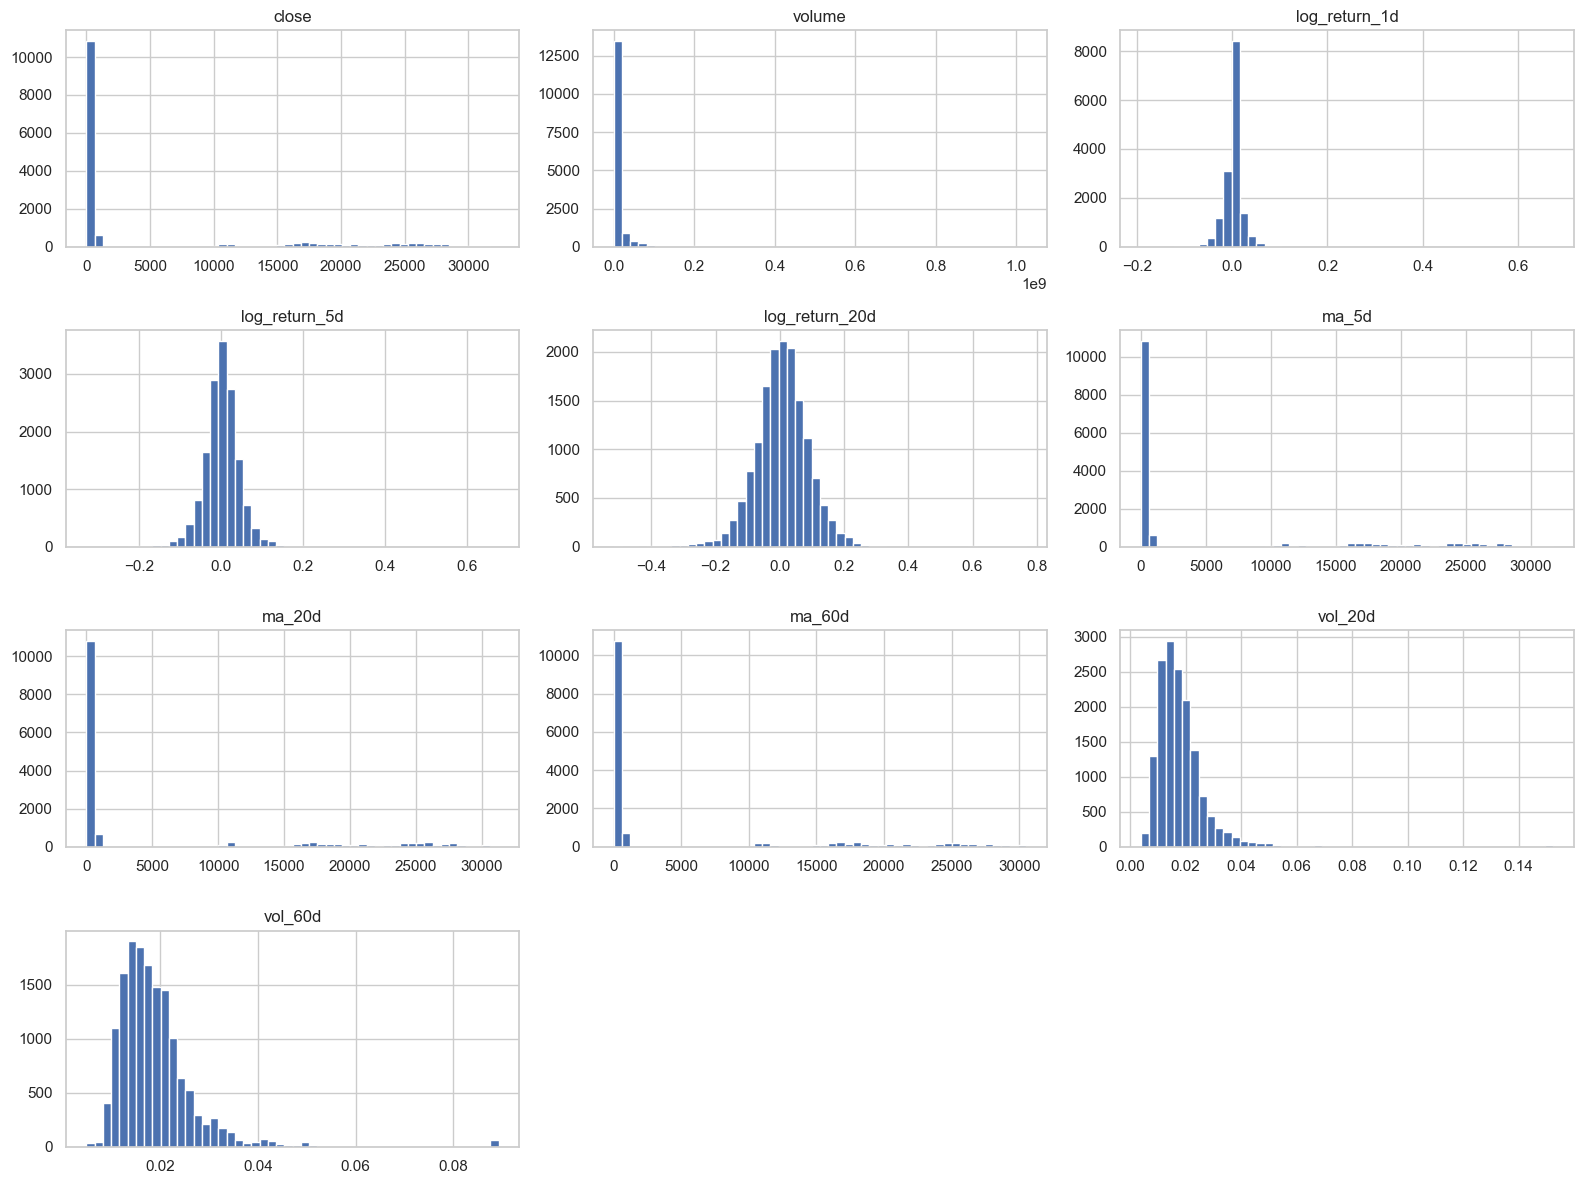

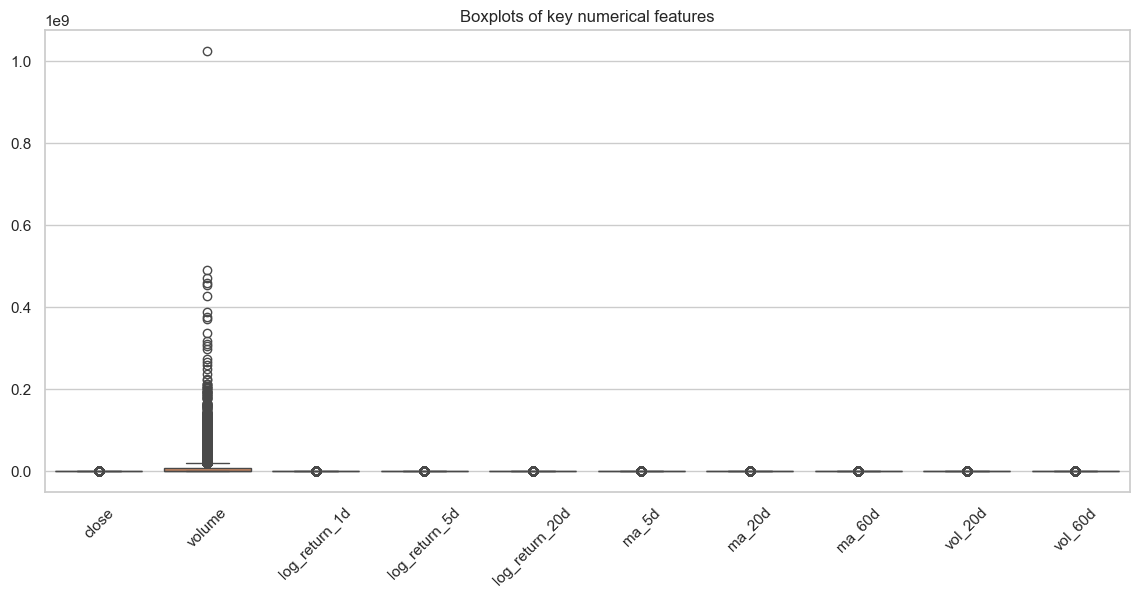

In [17]:
import numpy as np

num_cols = [
    "close", "volume", 
    "log_return_1d", "log_return_5d", "log_return_20d",
    "ma_5d", "ma_20d", "ma_60d",
    "vol_20d", "vol_60d",
]

num_cols = [c for c in num_cols if c in daily.columns]

# 1) Replace inf/-inf with NaN
daily_plot = daily.copy()
daily_plot[num_cols] = daily_plot[num_cols].replace([np.inf, -np.inf], np.nan)

# 2) Drop rows where all selected cols are NaN
daily_plot = daily_plot.dropna(subset=num_cols, how="all")

# 3) (Optional) Drop rows where a specific key column is NaN, e.g. log_return_1d
# daily_plot = daily_plot.dropna(subset=["log_return_1d"])

# Histograms
daily_plot[num_cols].hist(bins=50, figsize=(16, 12))
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=daily_plot[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplots of key numerical features")
plt.show()

##### Check the correlation and histograms company wise


=== AMBUJACEM ===


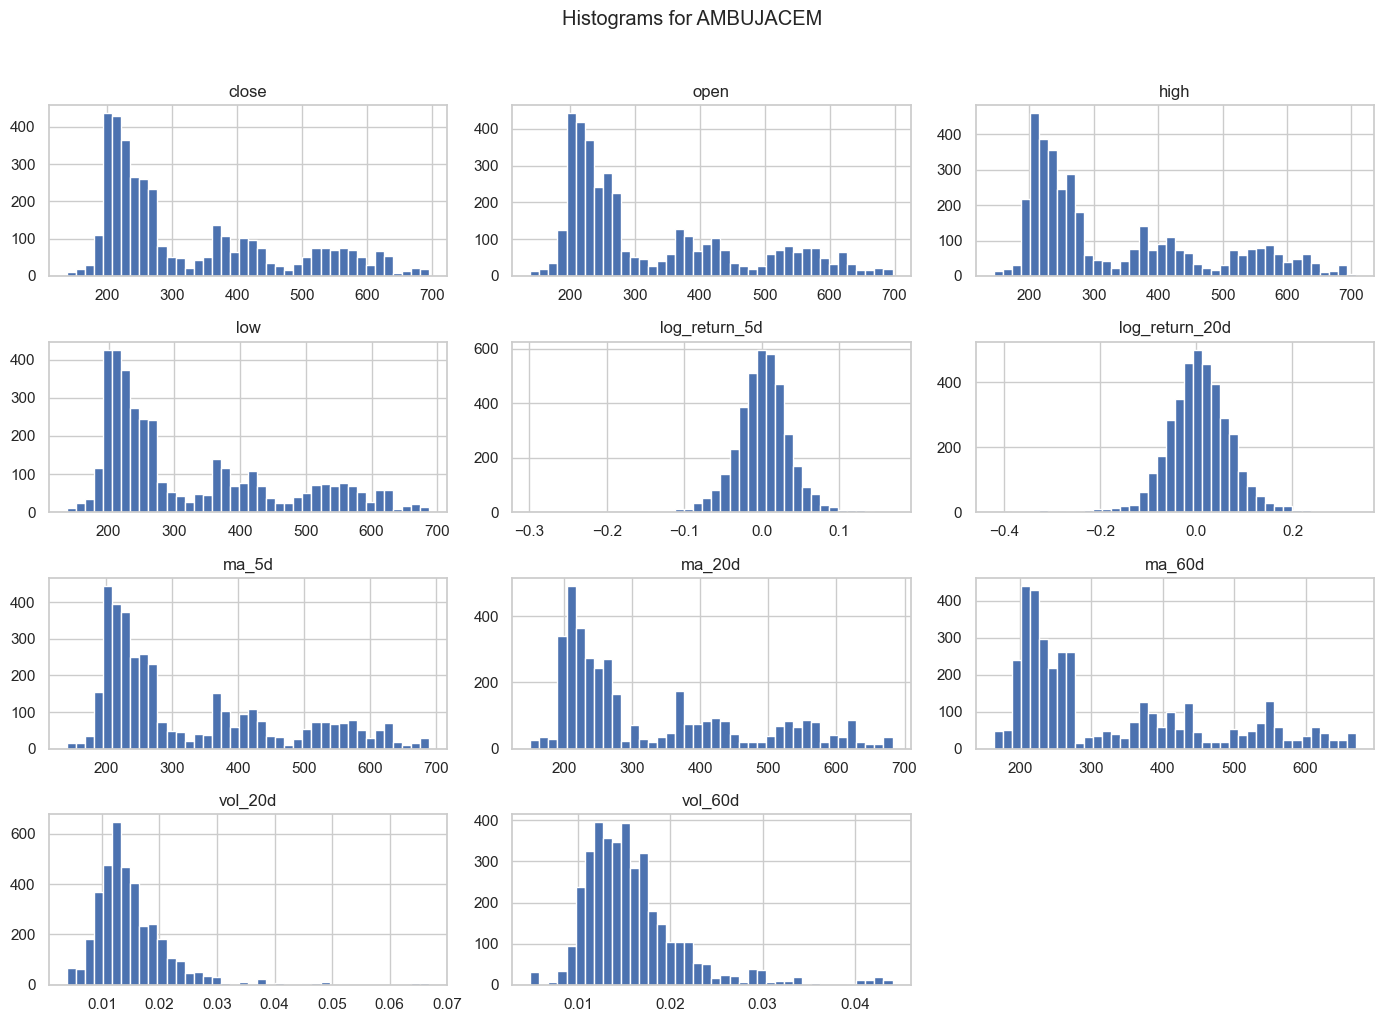

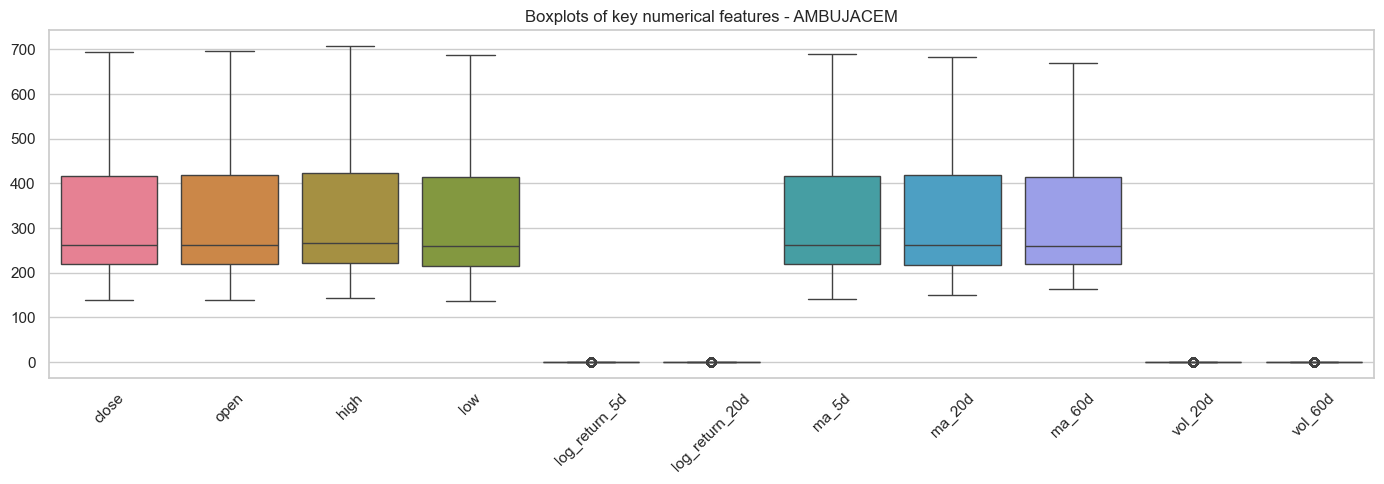


=== DLF ===


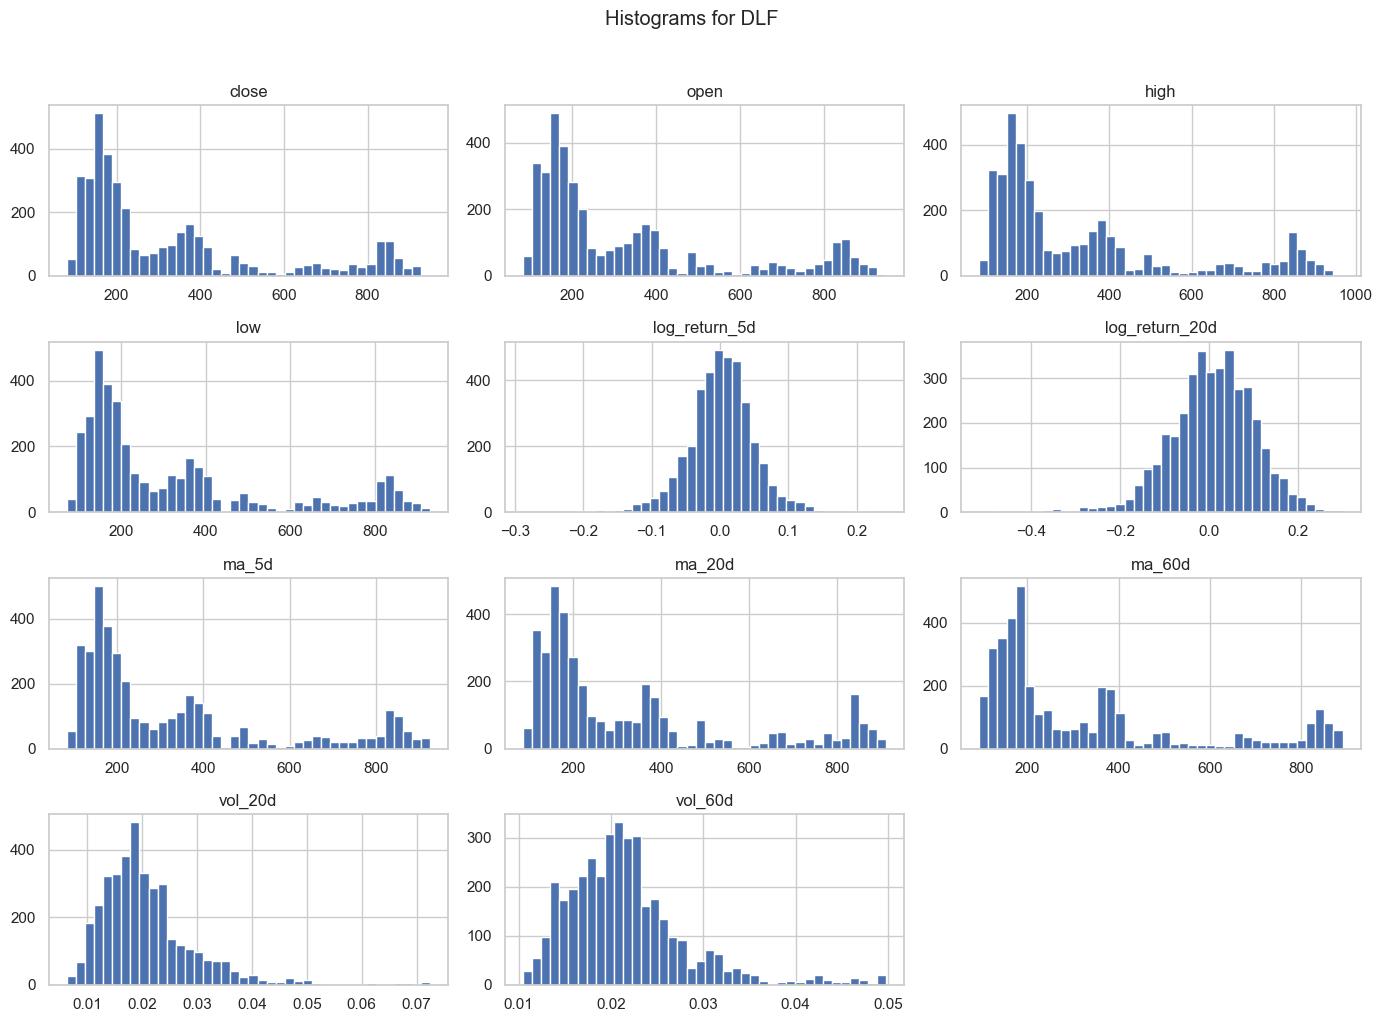

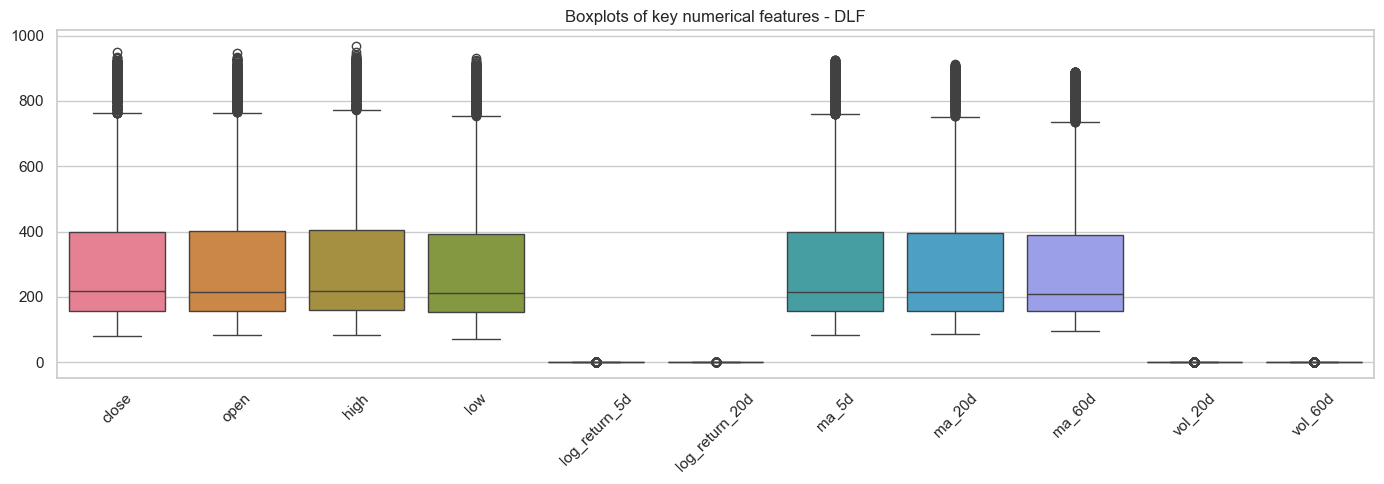


=== NMDC ===


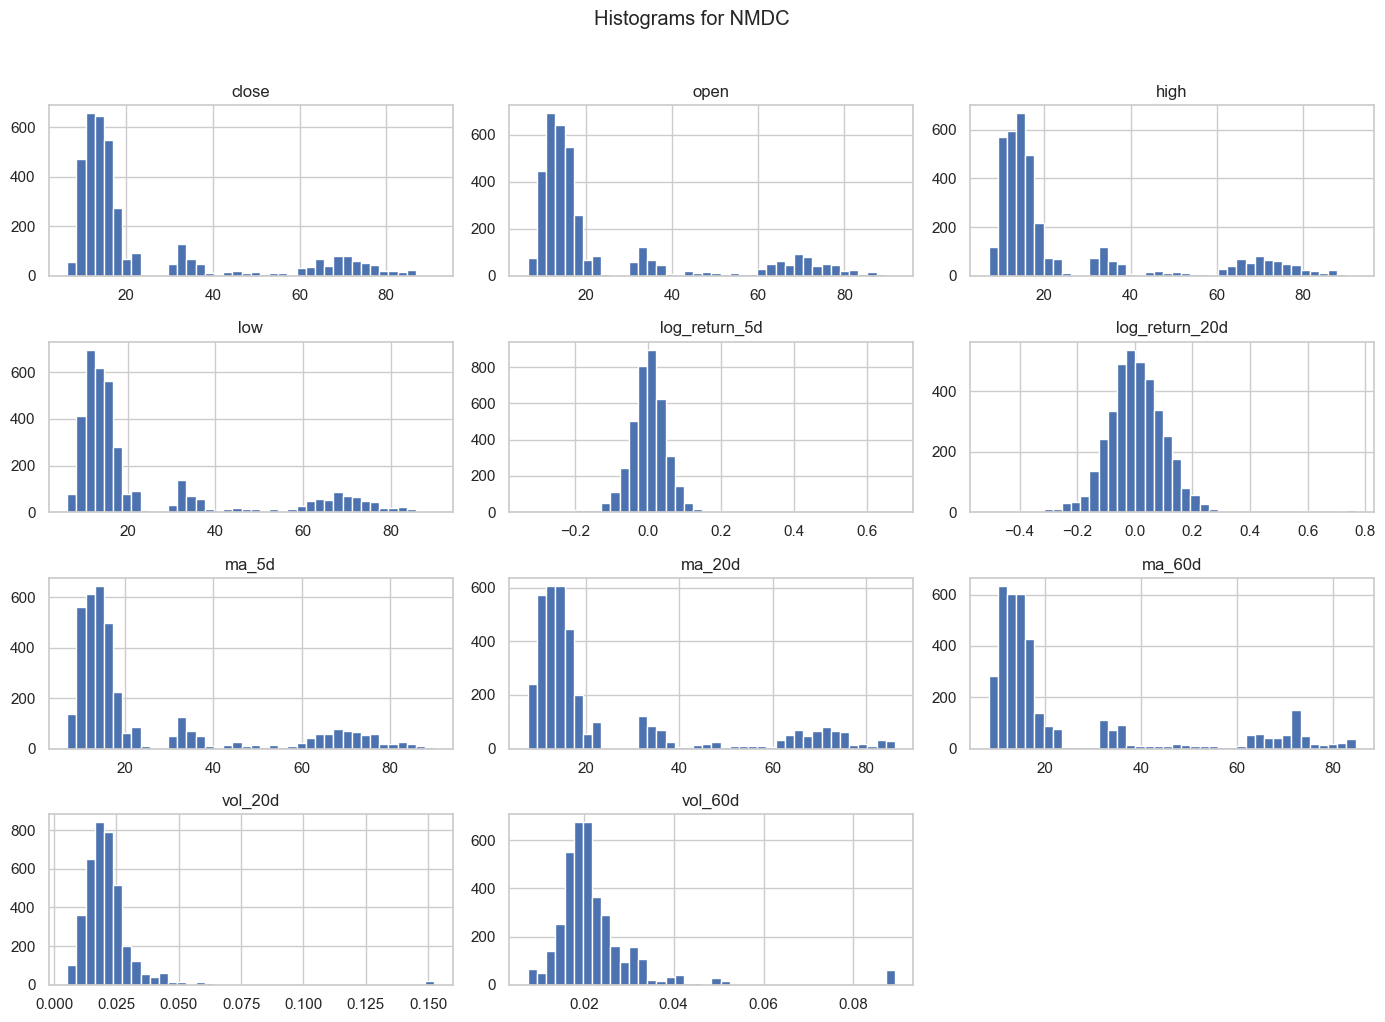

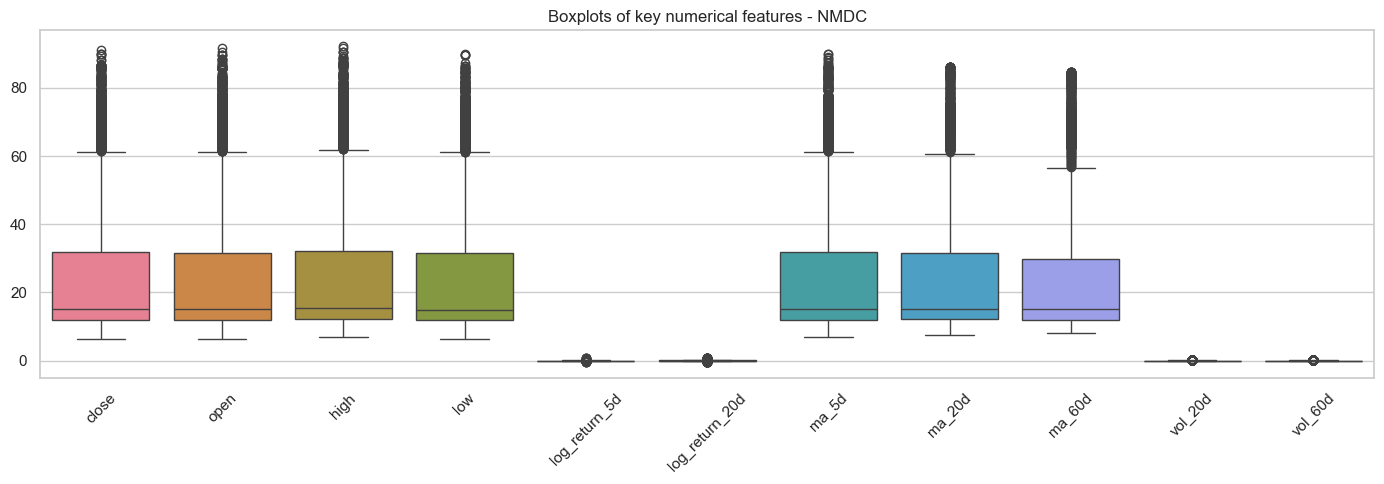


=== SHREECEM ===


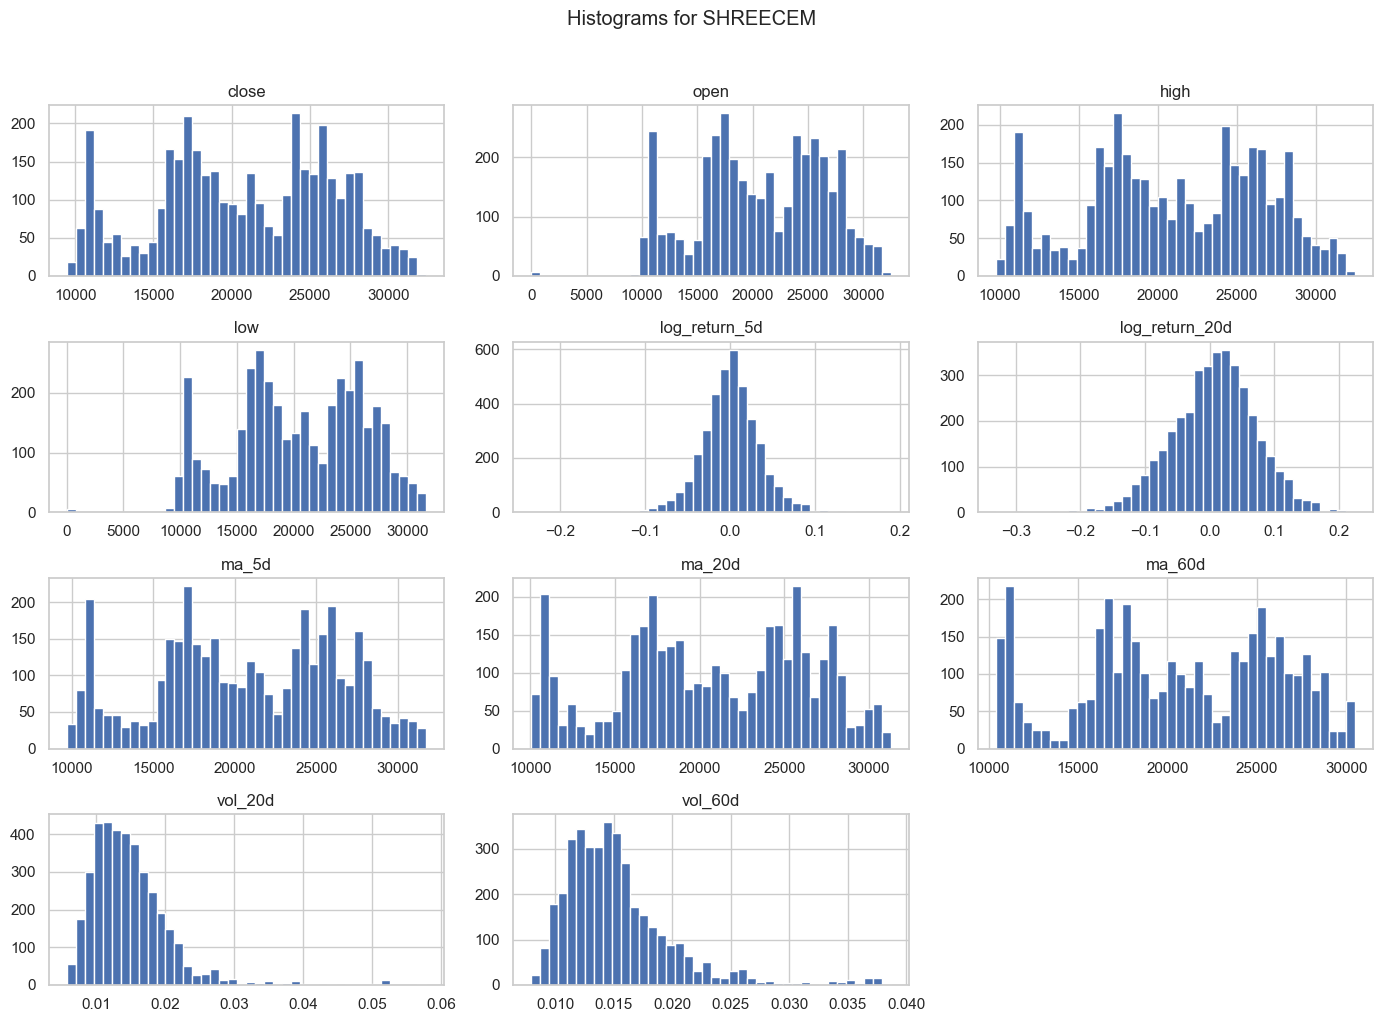

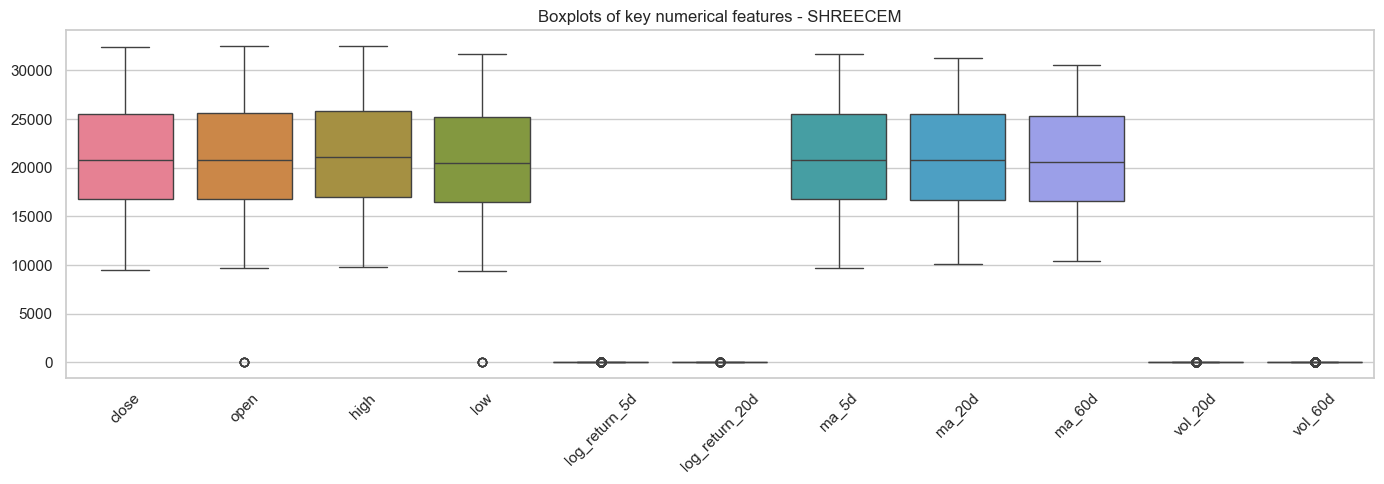

In [18]:
import numpy as np

# Choose columns to plot
num_cols = [
    "close", "open" , "high", "low",  "volume"
    "log_return_1d", "log_return_5d", "log_return_20d",
    "ma_5d", "ma_20d", "ma_60d",
    "vol_20d", "vol_60d",
]
num_cols = [c for c in num_cols if c in daily.columns]

companies = daily["company_name"].unique()

# Limit to first N companies if you want fewer plots
# companies = companies[:5]

for cname in companies:
    df_c = daily[daily["company_name"] == cname].copy()
    
    # Replace inf/-inf with NaN
    df_c[num_cols] = df_c[num_cols].replace([np.inf, -np.inf], np.nan)
    
    # Drop rows where all selected columns are NaN
    df_c = df_c.dropna(subset=num_cols, how="all")
    
    if df_c.empty:
        print(f"Skipping {cname}: no finite data for selected columns.")
        continue

    print(f"\n=== {cname} ===")

    # Histograms
    df_c[num_cols].hist(bins=40, figsize=(14, 10))
    plt.suptitle(f"Histograms for {cname}", y=1.02)
    plt.tight_layout()
    plt.show()

    # Boxplots
    plt.figure(figsize=(14, 5))
    sns.boxplot(data=df_c[num_cols])
    plt.xticks(rotation=45)
    plt.title(f"Boxplots of key numerical features - {cname}")
    plt.tight_layout()
    plt.show()

##### Time-series plots for a few sample companies

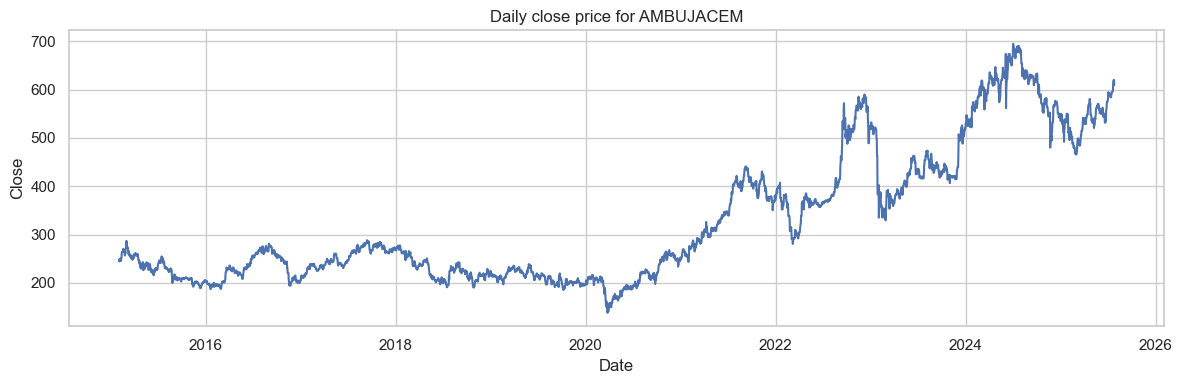

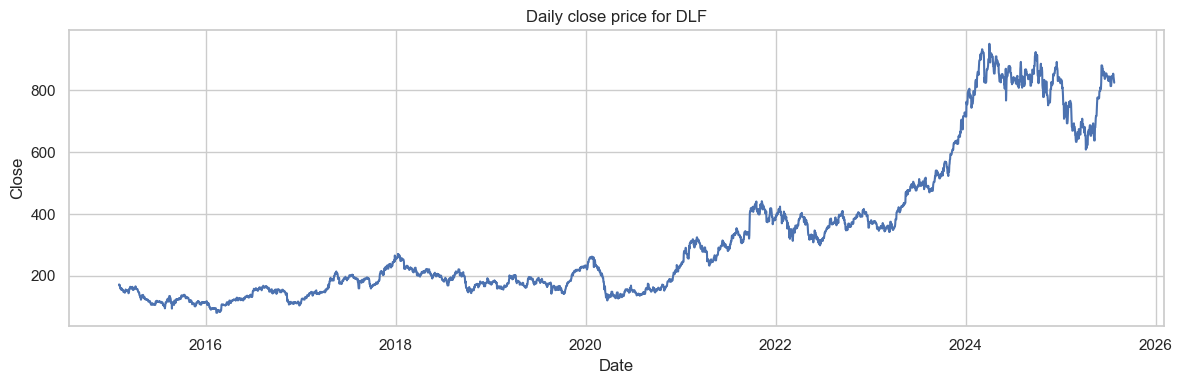

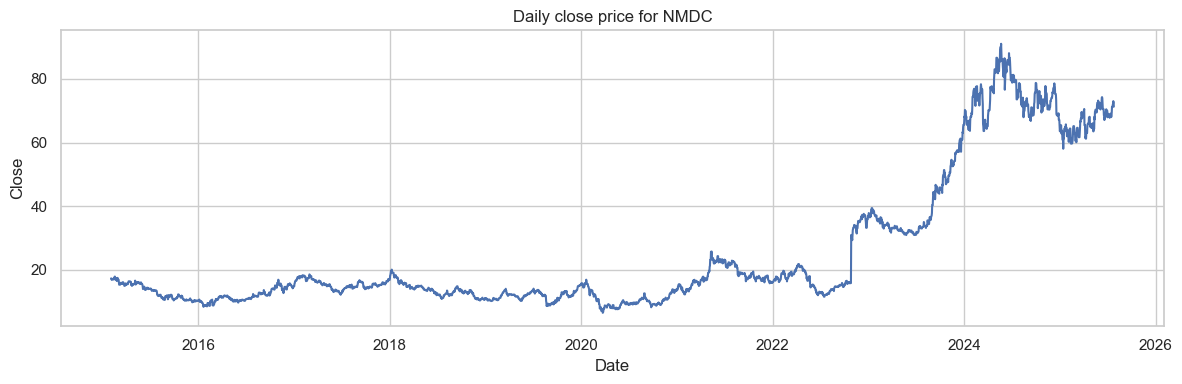

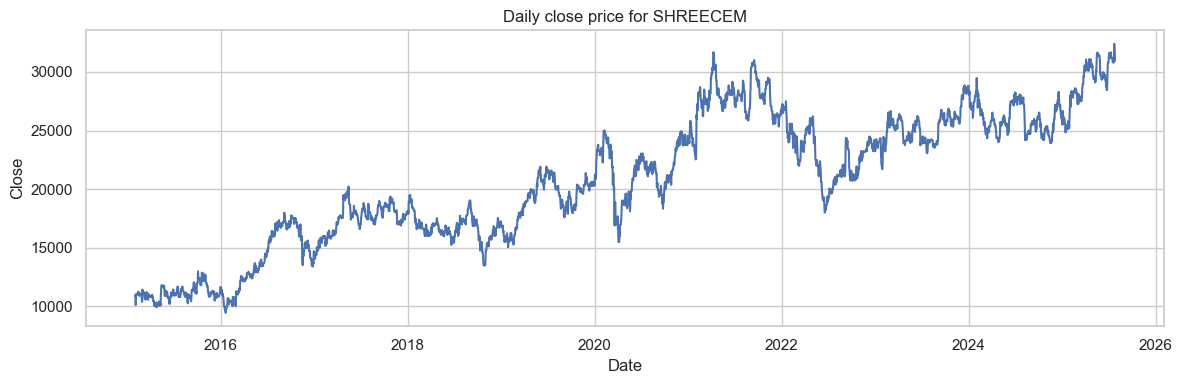

In [19]:
sample_companies = daily["company_name"].unique()[:]

for cname in sample_companies:
    df_c = daily[daily["company_name"] == cname]
    
    plt.figure(figsize=(12, 4))
    plt.plot(df_c["date"], df_c["close"])
    plt.title(f"Daily close price for {cname}")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.tight_layout()
    plt.show()


##### 1. Summarize distributions numerically per company

In [22]:
features = [
    "close", "volume",
    "log_return_1d", "log_return_5d", "log_return_20d",
    "ma_5d", "ma_20d", "ma_60d",
    "vol_20d", "vol_60d",
]
features = [c for c in features if c in daily.columns]

summary = (
    daily
    .groupby("company_name")[features]
    .agg(["mean", "std", "min", "max"])
)

summary

close                                    volume  \
                     mean         std     min     max          mean   
company_name                                                          
BANDHANBNK     323.529313  134.600599   130.0   729.8  5.699736e+06   
CHOLAFIN       543.750379  437.400150   106.6  1664.9  1.336766e+06   
HDFCAMC       2692.498940  911.612591  1244.8  5619.5  3.159038e+05   
ICICIGI       1307.897342  351.018788   667.0  2273.0  4.614654e+05   
ICICIPRULI     482.935909  110.818131   236.0   791.2  1.285882e+06   
SBICARD        828.646272  123.413544   500.2  1144.9  1.273070e+06   

                                             log_return_1d            ...  \
                       std  min          max          mean       std  ...   
company_name                                                          ...   
BANDHANBNK    8.659930e+06  0.0  132203069.0     -0.000362  0.025159  ...   
CHOLAFIN      3.018469e+06  0.0   41536484.0      0.000688  0.021296  ...   
HDFCAMC       6.558445e+05  0.0   19296379.0      0.000445  0.016883  ...   
ICICIGI       1.251968e+06  0.0   34584336.0      0.000364  0.015868  ...   
ICICIPRULI    2.397831e+06  0.0   89034887.0      0.000229  0.017181  ...   
SBICARD       2.752820e+06  0.0   58828215.0      0.000139  0.016411  ...   

                   ma_60d                vol_20d                      \
                      min          max      mean       std       min   
company_name                                                           
BANDHANBNK     143.376500   678.235000  0.021510  0.013104  0.000000   
CHOLAFIN       108.000000  1589.720000  0.018815  0.010167  0.005255   
HDFCAMC       1341.601667  5089.098333  0.015388  0.006932  0.004362   
ICICIGI        680.075000  2148.202500  0.014298  0.007187  0.002827   
ICICIPRULI     295.750000   755.905833  0.015484  0.007559  0.003817   
SBICARD        550.881667  1094.240833  0.014882  0.008327  0.004003   

                         vol_60d                                
                   max      mean       std       min       max  
company_name                                                    
BANDHANBNK    0.136737  0.022495  0.011345  0.011635  0.089120  
CHOLAFIN      0.104291  0.019379  0.008978  0.009724  0.079464  
HDFCAMC       0.055965  0.015990  0.005475  0.008114  0.039413  
ICICIGI       0.076008  0.014731  0.006069  0.006017  0.050456  
ICICIPRULI    0.089036  0.016003  0.006374  0.008426  0.058401  
SBICARD       0.098157  0.015605  0.008093  0.007066  0.086303  

[6 rows x 40 columns]

##### 2. Quantify outliers and tail risk

In [50]:
def outlier_ratio(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return ((s < lower) | (s > upper)).mean()

outlier_stats = (
    daily
    .groupby("company_name")["log_return_1d"]
    .apply(outlier_ratio)
    .reset_index(name="outlier_ratio_log_return_1d")
)

outlier_stats.sort_values("outlier_ratio_log_return_1d", ascending=False)

,company_name,outlier_ratio_log_return_1d
16,IRCTC,0.436634
3,ATGL,0.211405
0,ADANIGREEN,0.202312
1,ADANIPOWER,0.190750
24,SHREECEM,0.187876
21,NMDC,0.185785
6,BLUEDART,0.182127
10,DMART,0.181043
13,HDFCAMC,0.177926
11,GAIL,0.174288


##### 3. Compare volatility and volume across companies

In [51]:
vol_liq = (
    daily
    .groupby("company_name")
    .agg(
        avg_volatility=("log_return_1d", "std"),
        avg_volume=("volume", "mean")
    )
    .reset_index()
)

vol_liq.sort_values("avg_volatility", ascending=False).head()
vol_liq.sort_values("avg_volume", ascending=False)

,company_name,avg_volatility,avg_volume
21,NMDC,0.025006,2.855894e+07
11,GAIL,0.018328,9.263115e+06
1,ADANIPOWER,0.028266,8.267487e+06
4,BANDHANBNK,0.025159,5.699736e+06
9,DLF,0.022524,5.556610e+06
2,AMBUJACEM,0.016895,2.843310e+06
16,IRCTC,0.030402,2.236486e+06
17,JSWENERGY,NaN,2.227890e+06
8,DABUR,0.012102,1.443131e+06
7,CHOLAFIN,0.021296,1.336766e+06


##### 4. Relate price trend and volatility

In [52]:
# Approximate trend as correlation(date, close) per company
trend_stats = (
    daily
    .assign(date_ordinal=daily["date"].map(pd.Timestamp.toordinal))
    .groupby("company_name")
    .apply(lambda g: g["date_ordinal"].corr(g["close"]))
    .reset_index(name="trend_corr")
)

trend_stats.sort_values("trend_corr", ascending=False)   # strong uptrend
trend_stats.sort_values("trend_corr")                # flat/declining

/var/folders/wv/ygt32m016zv4b7r2wb1yllnm0000gn/T/ipykernel_47548/2199372416.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily


,company_name,trend_corr
4,BANDHANBNK,-0.881425
23,SBICARD,-0.175699
3,ATGL,0.313108
6,BLUEDART,0.357499
13,HDFCAMC,0.670812
0,ADANIGREEN,0.676387
11,GAIL,0.681727
21,NMDC,0.748883
15,ICICIPRULI,0.783830
17,JSWENERGY,0.809110


In [53]:
from pathlib import Path
import shutil

# Base data folder (adjust if needed)
data_folder = Path("../Data")     # from EDA notebook
target_folder = data_folder / "Data_25_companies"

target_folder.mkdir(exist_ok=True)

selected_files = [
    "DMART_minute.csv",
    "ICICIPRULI_minute.csv",
    "DLF_minute.csv",
    "ADANIGREEN_minute.csv",
    "AMBUJACEM_minute.csv",
    "JSWENERGY_minute.csv",
    "BANDHANBNK_minute.csv",
    "DABUR_minute.csv",
    "CHOLAFIN_minute.csv",
    "NAUKRI_minute.csv",
    "ADANIPOWER_minute.csv",
    "ATGL_minute.csv",
    "SHREECEM_minute.csv",
    "BERGEPAINT_minute.csv",
    "ICICIGI_minute.csv",
    "GODREJCP_minute.csv",
    "BLUEDART_minute.csv",
    "SBICARD_minute.csv",
    "NMDC_minute.csv",
    "PIDILITIND_minute.csv",
    "MARICO_minute.csv",
    "HDFCAMC_minute.csv",
    "LTTS_minute.csv",
    "GAIL_minute.csv",
    "IRCTC_minute.csv",
]

for fname in selected_files:
    src = data_folder / fname
    if src.exists():
        dst = target_folder / fname
        shutil.copy2(src, dst)
        print(f"Copied {fname}")
    else:
        print(f"Missing file (not copied): {fname}")

print("Done.")

Copied DMART_minute.csv
Copied ICICIPRULI_minute.csv
Copied DLF_minute.csv
Copied ADANIGREEN_minute.csv
Copied AMBUJACEM_minute.csv
Copied JSWENERGY_minute.csv
Copied BANDHANBNK_minute.csv
Copied DABUR_minute.csv
Copied CHOLAFIN_minute.csv
Copied NAUKRI_minute.csv
Copied ADANIPOWER_minute.csv
Copied ATGL_minute.csv
Copied SHREECEM_minute.csv
Copied BERGEPAINT_minute.csv
Copied ICICIGI_minute.csv
Copied GODREJCP_minute.csv
Copied BLUEDART_minute.csv
Copied SBICARD_minute.csv
Copied NMDC_minute.csv
Copied PIDILITIND_minute.csv
Copied MARICO_minute.csv
Copied HDFCAMC_minute.csv
Copied LTTS_minute.csv
Copied GAIL_minute.csv
Copied IRCTC_minute.csv
Done.
